In [ ]:
import torch
import torch.nn as nn
from torch_geometric.nn import VGAE, GINEConv

import torch.nn.functional as F
from torch_geometric.loader import DataLoader
import numpy as np
import pandas as pd
from pathlib import Path

In [114]:
import random

def set_seed(seed=42):
    """Fixe toutes les graines aléatoires pour la reproductibilité"""
    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # si multi-GPU
    
    # NumPy
    np.random.seed(seed)
    
    # Python random
    random.seed(seed)    
    print(f"Seed fixée à: {seed}")

# Appeler au début
set_seed(42)

Seed fixée à: 42


In [115]:
def load_graphs(graph_dir):
    # Vérification du dossier
    graph_dir = Path(graph_dir)
    if not graph_dir.exists():
        raise FileNotFoundError(
            f"Le dossier '{graph_dir}' n'existe pas."
        )
    if not graph_dir.is_dir():
        raise NotADirectoryError(
            f"'{graph_dir}' n'est pas un dossier valide."
        )
    graphs = []
    # Charger tous les fichiers .pt
    for file_path in sorted(graph_dir.glob("*.pt")):
        try:
            g = torch.load(file_path)
            graphs.append(g)
            print(f"Graphe chargé : {file_path}")
        except Exception as e:
            print(f"Erreur lors du chargement de {file_path} : {e}")
    return graphs

# Charger les graphes
train_graphs_dir = "graphs/train"
test_graphs_dir = "graphs/test"

train_graphs = load_graphs(train_graphs_dir)
test_graphs = load_graphs(test_graphs_dir)

Graphe chargé : graphs/train/graph_batch_1.pt
Graphe chargé : graphs/train/graph_batch_10.pt
Graphe chargé : graphs/train/graph_batch_11.pt
Graphe chargé : graphs/train/graph_batch_12.pt
Graphe chargé : graphs/train/graph_batch_2.pt
Graphe chargé : graphs/train/graph_batch_3.pt
Graphe chargé : graphs/train/graph_batch_4.pt
Graphe chargé : graphs/train/graph_batch_5.pt
Graphe chargé : graphs/train/graph_batch_6.pt
Graphe chargé : graphs/train/graph_batch_7.pt
Graphe chargé : graphs/train/graph_batch_8.pt
Graphe chargé : graphs/train/graph_batch_9.pt
Graphe chargé : graphs/test/graph_batch_1.pt
Graphe chargé : graphs/test/graph_batch_2.pt
Graphe chargé : graphs/test/graph_batch_3.pt
Graphe chargé : graphs/test/graph_batch_4.pt
Graphe chargé : graphs/test/graph_batch_5.pt
Graphe chargé : graphs/test/graph_batch_6.pt
Graphe chargé : graphs/test/graph_batch_7.pt


/tmp/ipykernel_50836/3133579107.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  g = torch.load(file_path)


## Split temporel (train / val)

In [116]:
num_graphs = len(train_graphs)

train_ratio = 0.8

train_end = int(train_ratio * num_graphs)

val_graphs   = train_graphs[train_end:]
train_graphs = train_graphs[:train_end]


# Créer un DataLoader pour l'entraînement
# batch_size = nombre de graphes dans chaque batch
batch_size = 1

train_loader = DataLoader(
    train_graphs,
    batch_size=batch_size,
    shuffle=False
)

val_loader = DataLoader(
    val_graphs,
    batch_size=batch_size,
    shuffle=False
)

test_loader = DataLoader(
    test_graphs,
    batch_size=batch_size,
    shuffle=False
)

## Normalisation des features

In [117]:
# concaténation de tous les noeuds du TRAIN
node_xs = torch.cat([g.x for g in train_graphs], dim=0)
edge_xs = torch.cat([g.edge_attr for g in train_graphs], dim=0)

# Calcul des statistiques pour les nœuds
node_mean = node_xs.mean(dim=0)
node_std  = node_xs.std(dim=0, unbiased=False) + 1e-6

# Calcul des statistiques pour les arêtes
edge_mean = edge_xs.mean(dim=0)
edge_std  = edge_xs.std(dim=0, unbiased=False) + 1e-6

def normalize_graph(g, node_mean, node_std, edge_mean, edge_std):
    g = g.clone()
    g.x = (g.x - node_mean) / node_std
    g.edge_attr = (g.edge_attr - edge_mean) / edge_std
    return g


# Normalisation de tous les graphes
train_graphs = [normalize_graph(g, node_mean, node_std, edge_mean, edge_std) for g in train_graphs]
val_graphs   = [normalize_graph(g, node_mean, node_std, edge_mean, edge_std) for g in val_graphs]
test_graphs  = [normalize_graph(g, node_mean, node_std, edge_mean, edge_std) for g in test_graphs]

## Définir l’encodeur

In [118]:
class EdgeUpdate(nn.Module):
    def __init__(self, node_dim, edge_dim, hidden_dim, dropout=0.1):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(2 * node_dim + edge_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, edge_dim)
        )

    def forward(self, x, edge_index, edge_attr):
        src, dst = edge_index
        edge_input = torch.cat([x[src], x[dst], edge_attr], dim=1)
        return edge_attr + self.mlp(edge_input)  # 🔥 residual

class GineConvEncoder(nn.Module):
    def __init__(self, node_in_dim, edge_in_dim,
                 node_hidden_dim, edge_hidden_dim, latent_dim):
        super().__init__()

        self.edge_up1 = EdgeUpdate(node_in_dim, edge_in_dim, edge_hidden_dim)

        self.conv1 = GINEConv(
            nn=nn.Sequential(
                nn.Linear(node_in_dim, node_hidden_dim),
                nn.ReLU(),
                nn.Linear(node_hidden_dim, node_hidden_dim)
            ),
            edge_dim=edge_in_dim
        )

        self.edge_up2 = EdgeUpdate(node_hidden_dim, edge_in_dim, edge_hidden_dim)

        self.conv2 = GINEConv(
            nn=nn.Sequential(
                nn.Linear(node_hidden_dim, node_hidden_dim),
                nn.ReLU(),
                nn.Linear(node_hidden_dim, node_hidden_dim)
            ),
            edge_dim=edge_in_dim
        )

        self.edge_up3 = EdgeUpdate(node_hidden_dim, edge_in_dim, edge_hidden_dim)

        self.conv_mu = GINEConv(
            nn=nn.Sequential(
                nn.Linear(node_hidden_dim, latent_dim),
            ),
            edge_dim=edge_in_dim
        )

        self.conv_logvar = GINEConv(
            nn=nn.Sequential(
                nn.Linear(node_hidden_dim, latent_dim),
            ),
            edge_dim=edge_in_dim
        )

    def forward(self, x, edge_index, edge_attr):
        edge_attr = self.edge_up1(x, edge_index, edge_attr)

        x = F.relu(self.conv1(x, edge_index, edge_attr))

        edge_attr = self.edge_up2(x, edge_index, edge_attr)

        x = F.relu(self.conv2(x, edge_index, edge_attr))

        edge_attr = self.edge_up3(x, edge_index, edge_attr)

        mu = self.conv_mu(x, edge_index, edge_attr)
        logvar = self.conv_logvar(x, edge_index, edge_attr)

        return mu, logvar


## Créer le modèle VGAE

In [119]:
# Dimensions extraites du graphe
node_in_dim = train_graphs[0].x.shape[1]
edge_in_dim = train_graphs[0].edge_attr.shape[1]

# Dimensions internes
node_hidden_dim = 64        # embeddings intermédiaires des nœuds
edge_hidden_dim = 32        # embeddings intermédiaires des arêtes

# Dimension latente VGAE
latent_dim = 32

encoder = GineConvEncoder(
    node_in_dim=node_in_dim,
    edge_in_dim=edge_in_dim,
    node_hidden_dim=node_hidden_dim,
    edge_hidden_dim=edge_hidden_dim,
    latent_dim=latent_dim
)

model = VGAE(encoder)

## Définir l’optimiseur

In [120]:
optimizer = torch.optim.AdamW(model.parameters(), lr= 5e-4, weight_decay=1e-4)

## Détecter le device (GPU si dispo)

In [121]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
# device = torch.device('cpu')

# Déplacer le modèle
model = model.to(device)

Using device: cuda


## Early Stopping

In [122]:
patience = 50  # nombre d'époques sans amélioration
best_loss = float('inf')
counter = 0

## Entraînement du modèle

In [123]:
num_epochs = 1000
kl_anneal_epochs = 200  # montée progressive de β


for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss = 0.0

    beta = min(1.0, epoch / kl_anneal_epochs)
    
    # ===== ENTRAÎNEMENT SUR LE PASSÉ =====
    for t, data in enumerate(train_loader):
        assert data.edge_index.dtype == torch.long
        assert data.edge_index.min() >= 0
        assert data.edge_index.max() < data.num_nodes
        # Chaque data = 1 graphe temporel
        data = data.to(device)

        optimizer.zero_grad()
        # Encodage VGAE (NNConv utilise edge_attr)
        z = model.encode(
            data.x,
            data.edge_index,
            data.edge_attr
        )
        # Loss VGAE = reconstruction + KL
        recon_loss = model.recon_loss(z, data.edge_index) / data.num_nodes  # normalisation
        kl_loss = model.kl_loss() / data.num_nodes  # normalisation
        loss = recon_loss + beta * kl_loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # ===== VALIDATION SUR LE FUTUR (SANS BACKPROP) =====
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)

            z = model.encode(
                data.x,
                data.edge_index,
                data.edge_attr
            )

            recon_loss = model.recon_loss(z, data.edge_index) / data.num_nodes  # normalisation
            kl_loss = model.kl_loss() / data.num_nodes

            val_loss += (recon_loss + kl_loss).item()

    print(
        f"Epoch {epoch:03d} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f}"
    )

    # ===== EARLY STOPPING TEMPOREL =====
    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "best_vgae_gineconv.pt")
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

Epoch 001 | Train Loss: 1640.8242 | Val Loss: 99169.5977
Epoch 002 | Train Loss: 1924.0955 | Val Loss: 61744.3691
Epoch 003 | Train Loss: 1787.8001 | Val Loss: 45760.1436
Epoch 004 | Train Loss: 1819.3582 | Val Loss: 33846.6299
Epoch 005 | Train Loss: 1334.4956 | Val Loss: 9209.0747
Epoch 006 | Train Loss: 263.5808 | Val Loss: 1432.1043
Epoch 007 | Train Loss: 73.8907 | Val Loss: 343.1426
Epoch 008 | Train Loss: 27.2365 | Val Loss: 204.9271
Epoch 009 | Train Loss: 19.2803 | Val Loss: 108.6144
Epoch 010 | Train Loss: 13.0815 | Val Loss: 66.8309
Epoch 011 | Train Loss: 9.2672 | Val Loss: 49.7321
Epoch 012 | Train Loss: 7.6967 | Val Loss: 36.0490
Epoch 013 | Train Loss: 6.3446 | Val Loss: 28.7577
Epoch 014 | Train Loss: 5.4296 | Val Loss: 37.4473
Epoch 015 | Train Loss: 6.8836 | Val Loss: 26.7990
Epoch 016 | Train Loss: 6.2075 | Val Loss: 24.8074
Epoch 017 | Train Loss: 5.5211 | Val Loss: 19.2816
Epoch 018 | Train Loss: 4.4486 | Val Loss: 14.6997
Epoch 019 | Train Loss: 3.5929 | Val Loss:

## Charger le modèle

In [124]:
# Charger le meilleur modèle
model.load_state_dict(torch.load("best_vgae_gineconv.pt"))


/tmp/ipykernel_50836/284174333.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_vgae_gineconv.pt"))


<All keys matched successfully>

## Score de reconstruction

In [125]:
def edge_recon_error(z, edge_index):
    src, dst = edge_index
    logits = (z[src] * z[dst]).sum(dim=1)
    probs = torch.sigmoid(logits)
    error = -torch.log(probs + 1e-9)
    return error  # [num_edges]


## Agrégation vers les NŒUDS

In [126]:
def node_anomaly_score(z, edge_index, num_nodes):
    edge_error = edge_recon_error(z, edge_index)

    src, dst = edge_index
    node_score = torch.zeros(num_nodes, device=z.device)
    node_score.scatter_add_(0, src, edge_error)
    node_score.scatter_add_(0, dst, edge_error)

    degree = torch.zeros(num_nodes, device=z.device)
    degree.scatter_add_(0, src, torch.ones_like(edge_error))
    degree.scatter_add_(0, dst, torch.ones_like(edge_error))

    return node_score / (degree + 1e-6)


## Collecte sur les données de valisation

In [127]:
val_scores = []
val_labels = []

model.eval()
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)

        z = model.encode(
            data.x,
            data.edge_index,
            data.edge_attr
        )

        scores = node_anomaly_score(
            z,
            data.edge_index,
            data.num_nodes
        )

        print("data.y:", data.y)
        print("scores:", scores.shape)

        val_scores.extend(scores.cpu().numpy())
        val_labels.extend(data.y.cpu().numpy())


data.y: tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
scores: torch.Size([30058])
data.y: tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
scores: torch.Size([85848])
data.y: tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
scores: torch.Size([88759])
data.y: tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
scores: torch.Size([69533])
data.y: tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
scores: torch.Size([69348])
data.y: tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
scores: torch.Size([72635])
data.y: tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
scores: torch.Size([139538])


## Choisir un seuil

In [128]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(val_labels, val_scores)

# Exemple : maximiser F1
f1 = 2 * precision * recall / (precision + recall + 1e-9)
best_idx = np.argmax(f1)

best_threshold = thresholds[best_idx]
print("Best threshold:", best_threshold)
print("Precision:", precision[best_idx])
print("Recall:", recall[best_idx])


Best threshold: 0.0
Precision: 0.0038598644278853163
Recall: 1.0


In [129]:
threshold = best_threshold
# threshold = np.percentile(val_scores, 99)


## TEST

In [130]:
test_scores = []
test_labels = []
test_preds  = []
test_transaction_ids = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)

        z = model.encode(
            data.x,
            data.edge_index,
            data.edge_attr
        )

        scores = node_anomaly_score(
            z,
            data.edge_index,
            data.num_nodes
        )

        preds = (scores > threshold).long()

        test_scores.extend(scores.cpu().numpy())
        test_labels.extend(data.y.cpu().numpy())
        test_preds.extend(preds.cpu().numpy())
        test_transaction_ids.extend(data.tx_id.cpu().numpy())


In [131]:
test_transaction_df = pd.DataFrame({
    "transaction_id": test_transaction_ids,
    "score": test_scores,
    "prediction": test_preds,
    "label": test_labels
})

test_transaction_df.to_csv("predictions.csv", index=False)

## Matrice de confusion

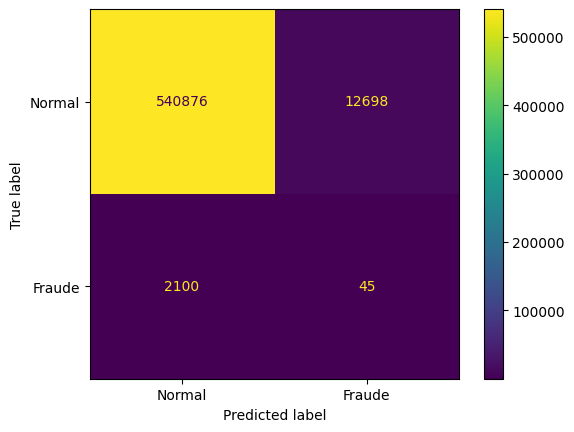

In [132]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_labels, test_preds)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Normal", "Fraude"]
)
disp.plot()
